In [85]:
from sympy import *
from sympy.printing import print_ccode
from sympy.combinatorics.permutations import Permutation
init_printing()
import numpy as np
from copy import deepcopy
import itertools


def gamma5(a,b):
    G5=np.array([np.array([1,0,0,0]),  
                np.array([0,1,0,0]),  
                np.array([0,0,-1,0]),   
                np.array([0,0,0,-1])
               ])
    return G5[a][b]


anti={}
anti['s']='sb'
anti['sb']='s'
anti['u']='ub'
anti['ub']='u'
anti['d']='db'
anti['db']='d'
anti['c']='cb'
anti['cb']='c'

latex={}
latex['s']='s'
latex['sb']='\overline{s}'
latex['u']='u'
latex['ub']='\overline{u}'
latex['d']='d'
latex['db']='\overline{d}'

def find(array,value):
    for i,a in enumerate(array):
        if a==value:
            return i
    return -1

def color_permutation(C1,C2,color1,color2):
    
    
    COLOR1=[]
    pos1=[]
    for ic1,c1 in enumerate(C1):
        if c1 in color1:
            COLOR1.append(c1)
            pos1.append(ic1)
    
    index1=np.argsort(COLOR1)
    new_pos1=np.array(pos1)[index1]
    perm1=Permutation(index1)
    sign1=perm1.signature()
    
    COLOR2=[]
    pos2=[]
    for ic2,c2 in enumerate(C2):
        if c2 in color2:
            COLOR2.append(c2)
            pos2.append(ic2)
    
    index2=np.argsort(COLOR2)
    new_pos2=np.array(pos2)[index2]
    perm2=Permutation(index2)
    sign2=perm2.signature()
    
    #print(index1,index2)
    CC1=deepcopy(C1)
    CC2=deepcopy(C2)
    for p1,n1 in zip(pos1,new_pos1):
        CC1[p1]=C1[n1]
    for p2,n2 in zip(pos2,new_pos2):
        CC2[p2]=C2[n2]
    
    #print(C1, CC1)
    #print(C2, CC2)
    color3=[]
    for c1,c2 in zip(CC1,CC2):
        color3.append(c1)
        color3.append(c2)
    
    return sign1*sign2, color3
            
    
def contraction(quark,i,output,OUTPUT):
    #print(quark)
    #all quark are contracted
    FLAG=True
    for q in quark:
        if q in anti:
            FLAG=False
            break
    if FLAG==True:
        output2=deepcopy(output)
        OUTPUT.append(output2)
        return 0
    if quark[i] not in anti:
        contraction(quark,i+1,output,OUTPUT)
    for k,q in enumerate(quark):
        if q not in anti: continue
        if quark[i]==anti[q]:
            output.append([i,k])
            quark[i]=quark[i].upper()
            quark[k]=quark[k].upper()
            contraction(quark,i+1,output,OUTPUT)
            #print(quark)
            output.pop(-1)
            quark[i]=quark[i].lower()
            quark[k]=quark[k].lower()
            #print(quark)

def print_propagator(OUTPUT,quark,spin,color,position,overall):
    PRINT=0
    cont=[]
    for output2 in OUTPUT:
        #print(quark)
        output=deepcopy(output2)
        #print(output)
        quark2=[]
        spin2=[]
        color2=[]
        position2=[]
        output_flat=np.concatenate(output)
        for out in output_flat:
            quark2.append(quark[out])
            spin2.append(spin[out])
            color2.append(color[out])
            position2.append(position[out])
            
        perm=Permutation(output_flat)
        sign=perm.signature()
        
        for out1 in output_flat[0::2]:
            if quark[out1].find('b') != -1:
                quark2[out1],quark2[out1+1]=quark2[out1+1],quark2[out1]
                spin2[out1],spin2[out1+1]=spin2[out1+1],spin2[out1]
                color2[out1],color2[out1+1]=color2[out1+1],color2[out1]
                position2[out1],position2[out1+1]=position2[out1+1],position2[out1]
                sign*=-1
        
        PRINTING=''
        
        for iq, (q,s1,s2,c1,c2,x,y) in enumerate(zip(quark2[::2],spin2[::2],spin2[1::2],color2[::2],color2[1::2],position2[::2],position2[1::2])):
            if q=='c':
                PRINTING+='C_{'+s1+s2+';'+x+y+'}^{'+c1+c2+'}'
            else:
                PRINTING+='S_{'+s1+s2+';'+x+y+'}^{'+c1+c2+'}'

        PRINT+=sign*overall*symbols(PRINTING)
    return PRINT
    

def print_propagator_with_diquark(OUTPUT,quark,spin,color,position,overall,diquark):
    #OUTPUT=deepcopy(OUTPUT2)
    PRINT_ALL=0

    cont=[]
    for output2 in OUTPUT:
        output=deepcopy(output2)
        # iteration for all spin combinations [(mu1,mu2),(nu1,nu2)] , -[(mu2,mu1),(nu1,nu2)] , -[(mu1,mu2),(nu2,nu1)] , [(mu2,mu1),(nu2,nu1)]
        for index in list(itertools.product(range(len(diquark)),repeat=len(diquark))): 
            sign=1
            if not sum(index)%2==0:
                sign*=-1
            spin2=deepcopy(spin)
            for ind, di in zip(index,diquark):
                new_di=list(itertools.permutations(di))[ind]
                spin2[di[0]],spin2[di[1]]=spin[new_di[0]],spin[new_di[1]]
                
            
            output_flat=np.concatenate(output)
            QUARK,SPIN,COLOR,POSITION=[],[],[],[]
            for k,out in enumerate(output_flat): #align quarks correspond to contraction
                QUARK.append(quark[out])
                SPIN.append(spin2[out])
                COLOR.append(color[out])
                POSITION.append(position[out])
            
            perm=Permutation(output_flat)
            sign*=perm.signature()
        
            PRINT=1
            for iq, (q,s1,s2,c1,c2,x,y) in enumerate(zip(QUARK[::2],SPIN[::2],SPIN[1::2],COLOR[::2],COLOR[1::2],POSITION[::2],POSITION[1::2])):
                PRINTING='S_{'+s1+s2+';'+x+y+'}^{'+c1+c2+'}'
                PRINT*=symbols(PRINTING)

            PRINT2=sign*overall
            PRINT_ALL+=PRINT2*PRINT
    return PRINT_ALL

def print_propagator_with_diquark_color(OUTPUT,quark,spin,color,position,overall,diquark, color_perm1, color_perm2):
    
    PRINT_ALL=0

    cont=[]
    for output2 in OUTPUT:
        output=deepcopy(output2)
        # iteration for all spin combinations [(mu1,mu2),(nu1,nu2)] , -[(mu2,mu1),(nu1,nu2)] , -[(mu1,mu2),(nu2,nu1)] , [(mu2,mu1),(nu2,nu1)]
        for index in list(itertools.product(range(len(diquark)),repeat=len(diquark))):
            sign=1
            if not sum(index)%2==0:
                sign*=-1
            spin2=deepcopy(spin)
            for ind, di in zip(index,diquark):
                new_di=list(itertools.permutations(di))[ind]
                spin2[di[0]],spin2[di[1]]=spin[new_di[0]],spin[new_di[1]]
            
            output_flat=np.concatenate(output)
            QUARK,SPIN,COLOR,POSITION=[],[],[],[]
            for k,out in enumerate(output_flat): #align quarks correspond to contraction
                QUARK.append(quark[out])
                SPIN.append(spin2[out])
                COLOR.append(color[out])
                POSITION.append(position[out])
            
            perm=Permutation(output_flat)
            sign*=perm.signature()
            
            # color ordering and compute sign from epsilon^{abc} epsilon^{a'b'c'} 
            COLOR1,COLOR2=COLOR[::2],COLOR[1::2] 
            sign_eps,COLOR3=color_permutation(COLOR1,COLOR2,color_perm1,color_perm2)
            
            # print(QUARK)
            # print(SPIN)
            # print(COLOR3)
            # print(POSITION)
            
            
            PRINT=1
            for iq, (q,s1,s2,c1,c2,x,y) in enumerate(zip(QUARK[::2],SPIN[::2],SPIN[1::2],COLOR3[::2],COLOR3[1::2],POSITION[::2],POSITION[1::2])):
                #PRINTING+='S_{'+s1+s2+';'+x+y+'}^{'+c1+c2+'}'
                PRINTING='S_{'+s1+s2+';'+x+y+'}'
                PRINT*=symbols(PRINTING)
            PRINT2=sign*sign_eps*overall
            PRINT_ALL+=PRINT2*PRINT
    return PRINT_ALL

    
    
    
    
    
    
#     #OUTPUT=deepcopy(OUTPUT2)
#     PRINT_ALL=0

#     cont=[]
#     for output in OUTPUT:
#         #output=deepcopy(output2)
        
#         for index in list(itertools.product(range(len(diquark)),repeat=len(diquark))):
        
#             sign=1
            
#             if not sum(index)%2==0:
            
#                 sign*=-1
            
#             spin2=deepcopy(spin)
#             for ind, di in zip(index,diquark):
            
#                 new_di=list(itertools.permutations(di))[ind]
#                 spin2[di[0]],spin2[di[1]]=spin[new_di[0]],spin[new_di[1]]

                
                
#             COLOR1,COLOR2=[],[]
#             for out2 in output:
#                 out=deepcopy(out2)                
#                 COLOR1.append(color[out[0]])
#                 COLOR2.append(color[out[1]])
            
#             sign_eps,color2=color_permutation(COLOR1,COLOR2,color_perm1,color_perm2)
            
#             #sign=sign*sign_eps
            
#             PRINT3=1
#             for k,out2 in enumerate(output):
#                 out=deepcopy(out2)
            
#                 if quark[out[0]].find('b') != -1:
#                     out[0],out[1]=out[1],out[0]
#                     sign*=-1
#                 perm=Permutation(np.concatenate(output))
#                 sign*=perm.signature()
#                 #sign*=(-1)**(abs(out[1]-out[0])+1)
                
#                 #PRINT='S_{'+spin2[out[0]]+spin2[out[1]]+';'+position[out[0]]+position[out[1]]+'}^{'+color2[2*k]+color2[2*k+1]+'}'
#                 PRINT='S^{'+spin2[out[0]]+spin2[out[1]]+'}_{'+position[out[0]]+position[out[1]]+'}'
#                 #if spin2[out[1]]=='\\alpha':
# #                    PRINT+='\gamma_{5}^{\\alpha\\beta}'
# #                if spin2[out[1]]=='\\sigma':
# #                    PRINT+='\gamma_{5}^{\\sigma\\rho}'
                
#                 PRINT3*=symbols(PRINT)
#             #perm=Permutation(np.concatenate(output))
#             #sign*=perm.signature()
    
#             PRINT2=sign*sign_eps*overall
            
#             PRINT_ALL+=PRINT2*PRINT3
       
#     return PRINT_ALL

In [2]:
def print_Trace(OUTPUT,quark,spin,color,position,overall,diquark,spin_pair):
    PRINT_ALL=0
    
    SIGN=[]
    for output in OUTPUT:
        sign=1
        for out in output:

            if quark[out[0]].find('b') != -1:
                out[0],out[1]=out[1],out[0]
                sign*=-1

            sign*=(-1)**(abs(out[1]-out[0])+1)
        SIGN.append(sign)

    output_flat=[]
    for sign,output in zip(SIGN,OUTPUT):
        sign2=deepcopy(sign)
        flat=np.concatenate(output)
        spin2=deepcopy(np.array(spin)[flat])
        flat=list(flat)
        diquark2=[]
        for di in diquark:
            diquark2.append([flat.index(di[0]),flat.index(di[1])])
        spin_pair2=[]
        for s in spin_pair:
            spin_pair2.append([flat.index(s[0]),flat.index(s[1])])
        spin_pair2=list(np.concatenate(spin_pair2))

        for index in list(itertools.product(range(len(diquark2)),repeat=len(diquark2))):
            sign3=deepcopy(sign2)
            spin3=deepcopy(spin2)
            spin_pair3=deepcopy(spin_pair2)

            if not sum(index)%2==0:
                sign3*=-1
            for ind, di in zip(index,diquark2):

                new_di=list(itertools.permutations(di))[ind]

                spin3[di[0]],spin3[di[1]]=spin2[new_di[0]],spin2[new_di[1]]
                spin_pair3[spin_pair2.index(di[0])],spin_pair3[spin_pair2.index(di[1])]=new_di[0],new_di[1]

            quark2=np.array(quark)[flat]
            position2=np.array(position)[flat]
            color2=np.array(color)[flat]

            Trace=[[]]
            start=0
            while(start < len(quark)):
                q_start=start
                s_index=spin_pair3.index(q_start+1)  
                Trace[-1].append(q_start) 
                Trace[-1].append(q_start+1) 
                while(q_start < len(quark)):

                    if s_index%2==0:
                        s_index2=s_index+1 
                    else:
                        s_index2=s_index-1            
                    if spin_pair3[s_index2]==q_start: 
                        break   

                    Trace[-1].append(spin_pair3[s_index2])   
                    Trace[-1].append(spin_pair3[s_index2]+1) 

                    s_index=spin_pair3.index((spin_pair3[s_index2]+1)%len(quark))
                if q_start >= len(quark):
                    break
                while(start < len(quark)):
                    start+=2

                    if start >= len(quark):
                        break

                    FLAG=False
                    for tr in Trace:
                        if find(tr,start) != -1:
                            FLAG=True  #find
                    if FLAG==False :
                        break
                if start >= len(quark):
                    break
                Trace.append([])

            # if sign3==1:
            #     PRINT2=symbols('1')
            # else:
            #     PRINT2=symbols('-1')
            PRINT2=sign3*overall #symbols(overall)
            PRINT=''
            for Tr in Trace:
                
                PRINT+='Tr['
                for tr in Tr[::2]:
                    PRINT+='S^{'+color2[tr]+color2[tr+1]+'}_{'+position2[tr]+position2[tr+1]+'}'
                    if spin3[tr+1]=='\\alpha' or spin3[tr+1]=='\\sigma':
                        PRINT+='\gamma_{5}'
                PRINT+=']'
                #print(PRINT)
            #print(PRINT)
            #print('')
            PRINT_ALL+=PRINT2*symbols(PRINT)
            
    return PRINT_ALL
            
def print_Trace_color(OUTPUT,quark,spin,color,position,overall,diquark,spin_pair,color_cont1,color_cont2):
    PRINT_ALL=0
    
    SIGN=[]
    for output in OUTPUT:
        sign=1
        for out in output:

            if quark[out[0]].find('b') != -1:
                out[0],out[1]=out[1],out[0]
                sign*=-1

            sign*=(-1)**(abs(out[1]-out[0])+1)
        SIGN.append(sign)

    output_flat=[]
    for sign,output in zip(SIGN,OUTPUT):
        sign2=deepcopy(sign)
        flat=np.concatenate(output)
        spin2=deepcopy(np.array(spin)[flat])
        flat=list(flat)
        diquark2=[]
        for di in diquark:
            diquark2.append([flat.index(di[0]),flat.index(di[1])])
        spin_pair2=[]
        for s in spin_pair:
            spin_pair2.append([flat.index(s[0]),flat.index(s[1])])
        spin_pair2=list(np.concatenate(spin_pair2))

        for index in list(itertools.product(range(len(diquark2)),repeat=len(diquark2))):
            sign3=deepcopy(sign2)
            spin3=deepcopy(spin2)
            spin_pair3=deepcopy(spin_pair2)

            if not sum(index)%2==0:
                sign3*=-1
            for ind, di in zip(index,diquark2):

                new_di=list(itertools.permutations(di))[ind]

                spin3[di[0]],spin3[di[1]]=spin2[new_di[0]],spin2[new_di[1]]
                spin_pair3[spin_pair2.index(di[0])],spin_pair3[spin_pair2.index(di[1])]=new_di[0],new_di[1]

            quark2=np.array(quark)[flat]
            position2=np.array(position)[flat]
            color2=np.array(color)[flat]

            Trace=[[]]
            start=0
            while(start < len(quark)):
                q_start=start
                s_index=spin_pair3.index(q_start+1)  
                Trace[-1].append(q_start) 
                Trace[-1].append(q_start+1) 
                while(q_start < len(quark)):

                    if s_index%2==0:
                        s_index2=s_index+1 
                    else:
                        s_index2=s_index-1            
                    if spin_pair3[s_index2]==q_start: 
                        break   

                    Trace[-1].append(spin_pair3[s_index2])   
                    Trace[-1].append(spin_pair3[s_index2]+1) 

                    s_index=spin_pair3.index((spin_pair3[s_index2]+1)%len(quark))
                if q_start >= len(quark):
                    break
                while(start < len(quark)):
                    start+=2

                    if start >= len(quark):
                        break

                    FLAG=False
                    for tr in Trace:
                        if find(tr,start) != -1:
                            FLAG=True  #find
                    if FLAG==False :
                        break
                if start >= len(quark):
                    break
                Trace.append([])

            # if sign3==1:
            #     PRINT2=symbols('1')
            # else:
            #     PRINT2=symbols('-1')
            #epsilon abc permutation
            COLOR1,COLOR2=[],[]
            for Tr in Trace:
                for tr in Tr[::2]:
                    COLOR1.append(color2[tr])
                    COLOR2.append(color2[tr+1])
            sign_eps,color3=color_permutation(COLOR1,COLOR2,color_cont1,color_cont2)
            
            
            PRINT2=sign3*sign_eps*overall #symbols(overall)
            PRINT3=1
            #PRINT=''
            for Tr in Trace:
                PRINT='Tr['
                for tr in Tr[::2]:
                    #PRINT+='S^{'+color3[tr]+color3[tr+1]+'}_{'+position2[tr]+position2[tr+1]+'}'
                    PRINT+='S_{'+position2[tr]+position2[tr+1]+'}'
                    if spin3[tr+1]=='\\alpha' or spin3[tr+1]=='\\sigma':
                        PRINT+='\gamma_{5}'
                PRINT+=']'
                PRINT3*=symbols(PRINT)
                #print(PRINT)
            #print(PRINT)
            #print('')
            PRINT_ALL+=PRINT2*PRINT3 #symbols(PRINT)
            
    return PRINT_ALL

    

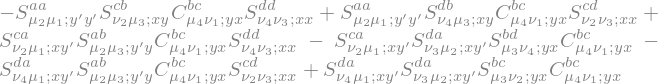

In [73]:

overall=1 #symbols('\Gamma_{\mu_1 \mu_2} \Gamma_{\mu_3 \mu_4} \Gamma_{\nu_3 \nu_4} \Gamma_{\nu_1 \nu_2}') #*symbols('\epsilon_{abc}\epsilon_{a\'b\'c\'}')

position=['y\'','y\'','y','y','x','x','x','x']
spin=['\\mu_1','\\mu_2','\\mu_3','\\mu_4','\\nu_1','\\nu_2','\\nu_3','\\nu_4']
#spin=['1','2','1','1','2','1']
color=['a','a','b','b','c','c','d','d']
#color=['2','1','0','0','1','2']
quark=['sb','s','sb','c','cb','s','sb','s']

#diquark=[[1,2],[3,4]]
#diquark=[]
#spin_pair=[[0,5],[1,4],[2,3]]
#color1=['a','b']
#color2=['a\'','b\'']
#color1=['0','1','2']
#color2=['0','1','2']

output=[]
OUTPUT=[]

contraction(quark,0,output,OUTPUT)

#print(OUTPUT)
#PRINT=print_Trace_color(OUTPUT,quark,spin,color,position,overall2,diquark,spin_pair,color1,color2)
#display(simplify(PRINT))

#PRINT=print_propagator_with_diquark_color(OUTPUT,quark,spin,color,position,overall2,diquark, color1, color2)
#display(simplify(PRINT))



display(print_propagator(OUTPUT,quark,spin,color,position,overall))



# Test $D \pi$

# 15 state

In [48]:

overall=1 #'\Gamma_{\mu_1 \mu_2} \Gamma_{\mu_3 \mu_4} \Gamma_{\nu_3 \nu_4} \Gamma_{\nu_1 \nu_2}' #*symbols('\epsilon_{abc}\epsilon_{a\'b\'c\'}')

position=['y','y','y','y','x','x','x','x']
spin=['\\mu_1','\\mu_2','\\mu_3','\\mu_4','\\nu_4','\\nu_3','\\nu_2','\\nu_1']
#spin=['1','2','1','1','2','1']
color=['c','c','b','b','b\'','b\'','c\'','c\'']
#color=['2','1','0','0','1','2']
quark=['db','c','db','u','ub','d','cb','d']

#diquark=[[1,2],[3,4]]
#diquark=[]
#spin_pair=[[0,5],[1,4],[2,3]]
#color1=['a','b']
#color2=['a\'','b\'']
#color1=['0','1','2']
#color2=['0','1','2']

output=[]
OUTPUT=[]

contraction(quark,0,output,OUTPUT)

#print(OUTPUT)
#PRINT=print_Trace_color(OUTPUT,quark,spin,color,position,overall2,diquark,spin_pair,color1,color2)
#display(simplify(PRINT))

#PRINT=print_propagator_with_diquark_color(OUTPUT,quark,spin,color,position,overall2,diquark, color1, color2)
#display(simplify(PRINT))



display(print_propagator(OUTPUT,quark,spin,color,position,overall))



# for a in ['0','1','2']:
#     color[2]=a
#     for b in ['0','1','2']:
#         if a==b: continue
#         color[1]=b
#         for c in ['0','1','2']:
#             if c==a or c==b: continue
#             color[0]=c
#             for aa in ['0','1','2']:
#                 color[3]=aa
#                 for bb in ['0','1','2']:
#                     if aa==bb: continue
#                     color[4]=bb
#                     for cc in ['0','1','2']:
#                         if cc==aa or cc==bb: continue
#                         color[5]=cc
#                         #print(color)
#                         perm1=Permutation(color[:3])
#                         perm2=Permutation(color[3:])

#                         sign1=perm1.signature()
#                         sign2=perm2.signature()
#                         #print(sign1, sign2)
                        
#                         PRINT2=sign1*sign2*print_propagator_with_diquark_color(OUTPUT,quark,spin,color,position,overall2,diquark, color1, color2)
#                         #display(PRINT2)
#                         PRINT+=PRINT2
#display(simplify(PRINT))


# 6 state

In [49]:

position=['y','y','y','y','x','x','x','x']
spin=['\\mu_1','\\mu_2','\\mu_3','\\mu_4','\\nu_4','\\nu_3','\\nu_2','\\nu_1']
#spin=['1','2','1','1','2','1']
color=['c','c','b','b','b\'','b\'','c\'','c\'']
#color=['2','1','0','0','1','2']
quark1=['sb','c','db','u','ub','d','cb','s']
quark2=['db','c','sb','u','ub','s','cb','d']
quark3=['sb','c','db','u','ub','s','cb','d']
quark4=['db','c','sb','u','ub','d','cb','s']

#diquark=[[1,2],[3,4]]
#diquark=[]
#spin_pair=[[0,5],[1,4],[2,3]]
#color1=['a','b']
#color2=['a\'','b\'']
#color1=['0','1','2']
#color2=['0','1','2']
PRINT=0
output=[]
OUTPUT=[]
overall2=1/2#'1/2\gamma_{5;\mu_1 \mu_2} \gamma_{5;\mu_3 \mu_4} \gamma_{5;\nu_3 \nu_4} \gamma_{5;;\nu_1 \nu_2}'#*symbols('\epsilon_{abc}\epsilon_{a\'b\'c\'}')
contraction(quark1,0,output,OUTPUT)
PRINT+=(print_propagator(OUTPUT,quark1,spin,color,position,overall2))


output=[]
OUTPUT=[]
overall2=1/2#'1/2\gamma_{5;\mu_1 \mu_2} \gamma_{5;\mu_3 \mu_4} \gamma_{5;\nu_3 \nu_4} \gamma_{5;;\nu_1 \nu_2}'#*symbols('\epsilon_{abc}\epsilon_{a\'b\'c\'}')
contraction(quark2,0,output,OUTPUT)
PRINT+=(print_propagator(OUTPUT,quark2,spin,color,position,overall2))

output=[]
OUTPUT=[]
overall2=-1/2#'-1/2\gamma_{5;\mu_1 \mu_2} \gamma_{5;\mu_3 \mu_4} \gamma_{5;\nu_3 \nu_4} \gamma_{5;;\nu_1 \nu_2}'#*symbols('\epsilon_{abc}\epsilon_{a\'b\'c\'}')
contraction(quark3,0,output,OUTPUT)
PRINT+=(print_propagator(OUTPUT,quark3,spin,color,position,overall2))

output=[]
OUTPUT=[]
overall2=-1/2#'-1/2\gamma_{5;\mu_1 \mu_2} \gamma_{5;\mu_3 \mu_4} \gamma_{5;\nu_3 \nu_4} \gamma_{5;;\nu_1 \nu_2}'#*symbols('\epsilon_{abc}\epsilon_{a\'b\'c\'}')
contraction(quark4,0,output,OUTPUT)
PRINT+=(print_propagator(OUTPUT,quark4,spin,color,position,overall2))

display(PRINT)
#PRINT=print_Trace_color(OUTPUT,quark,spin,color,position,overall2,diquark,spin_pair,color1,color2)
#display(simplify(PRINT))

#PRINT=print_propagator_with_diquark_color(OUTPUT,quark,spin,color,position,overall2,diquark, color1, color2)
#display(simplify(PRINT))







# for a in ['0','1','2']:
#     color[2]=a
#     for b in ['0','1','2']:
#         if a==b: continue
#         color[1]=b
#         for c in ['0','1','2']:
#             if c==a or c==b: continue
#             color[0]=c
#             for aa in ['0','1','2']:
#                 color[3]=aa
#                 for bb in ['0','1','2']:
#                     if aa==bb: continue
#                     color[4]=bb
#                     for cc in ['0','1','2']:
#                         if cc==aa or cc==bb: continue
#                         color[5]=cc
#                         #print(color)
#                         perm1=Permutation(color[:3])
#                         perm2=Permutation(color[3:])

#                         sign1=perm1.signature()
#                         sign2=perm2.signature()
#                         #print(sign1, sign2)
                        
#                         PRINT2=sign1*sign2*print_propagator_with_diquark_color(OUTPUT,quark,spin,color,position,overall2,diquark, color1, color2)
#                         #display(PRINT2)
#                         PRINT+=PRINT2
#display(simplify(PRINT))


# $\bar{3}$ state

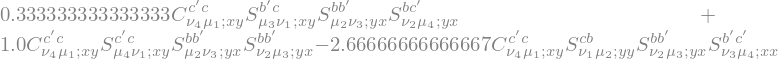

In [89]:
position=['y','y','y','y','x','x','x','x']
spin=['\\mu_1','\\nu_1','\\mu_2','\\nu_2','\\mu_3','\\nu_3','\\mu_4','\\nu_4']
#spin=['1','2','1','1','2','1']
color=['c','c','b','b','b\'','b\'','c\'','c\'']
#color=['2','1','0','0','1','2']

quark1=['cb','u','ub','u']
quark2=['cb','d','db','u']
quark3=['cb','u','db','d']
quark4=['cb','s','sb','u']
quark5=['cb','u','sb','s']

QUARK=[quark1,quark2,quark3,quark4,quark5]
overall=[np.sqrt(1/6),np.sqrt(3/8),-1/2/np.sqrt(6),np.sqrt(3/8),-1/2/np.sqrt(6)]
PRINT=0
for quark, over1 in zip(QUARK,overall):
    for quark2, over2 in zip(QUARK,overall):
        antiquark=[]
        for q in quark2:
            antiquark.append(anti[q])
        antiquark.reverse()
        #print(quark+antiquark, over1*over2)
        output=[]
        OUTPUT=[]
        contraction(quark+antiquark,0,output,OUTPUT)
#        print(OUTPUT)
        PRINT+=print_propagator(OUTPUT,quark+antiquark,spin,color,position,over1*over2)
           
#display(PRINT)


quark1=['cb','u','ub','d']
quark2=['cb','d','ub','u']
quark3=['cb','d','db','d']
quark4=['cb','s','sb','d']
quark5=['cb','d','sb','s']

QUARK=[quark1,quark2,quark3,quark4,quark5]
QUARK2=deepcopy(QUARK)
overall=[np.sqrt(3/8),-1/2/np.sqrt(6),1/np.sqrt(6),np.sqrt(3/8),-1/2/np.sqrt(6)]
PRINT=0
for quark, over1 in zip(QUARK,overall):
    for quark2, over2 in zip(QUARK2,overall):
        antiquark=[]
        for q in quark2:
            antiquark.append(anti[q])
        antiquark.reverse()
        #print(quark+antiquark, over1*over2)
        output=[]
        OUTPUT=[]
        contraction(quark+antiquark,0,output,OUTPUT)
        PRINT2=print_propagator(OUTPUT,quark+antiquark,spin,color,position,over1*over2)
        #display(PRINT2)
        PRINT+=PRINT2
           
display(PRINT)


# Test proton proton contraction

In [86]:
overall='\\frac{1}{2}\epsilon_{abc}\epsilon_{a\'b\'c\'}'
overall2=1/2#*symbols('\epsilon_{abc}\epsilon_{a\'b\'c\'}')
position=['y','y','y','x','x','x']
#spin=['\\mu_1','\\mu_2','\\mu_3','\\nu_3','\\nu_2','\\nu_1']
spin=['1','2','1','1','2','1']
color=['c','b','a','a\'','b\'','c\'']
#color=['2','1','0','0','1','2']
quark=['u','u','d','db','ub','ub']

diquark=[[1,2],[3,4]]
#diquark=[]
#spin_pair=[[0,5],[1,4],[2,3]]
color1=['a','b','c']
color2=['a\'','b\'','c\'']
#color1=['0','1','2']
#color2=['0','1','2']

output=[]
OUTPUT=[]

contraction(quark,0,output,OUTPUT)


#PRINT=print_Trace_color(OUTPUT,quark,spin,color,position,overall2,diquark,spin_pair,color1,color2)
#display(simplify(PRINT))

PRINT=print_propagator_with_diquark_color(OUTPUT,quark,spin,color,position,overall2,diquark, color1, color2)
#PRINT=print_propagator_with_diquark(OUTPUT,quark,spin,color,position,overall2,diquark)
display(simplify(PRINT))


# color1=['0','1','2']
# color2=['0','1','2']
# PRINT2=0
# for a in ['0','1','2']:
#     color[2]=a
#     for b in ['0','1','2']:
#         if a==b: continue
#         color[1]=b
#         for c in ['0','1','2']:
#             if c==a or c==b: continue
#             color[0]=c
#             for aa in ['0','1','2']:
#                 color[3]=aa
#                 for bb in ['0','1','2']:
#                     if aa==bb:continue
#                     color[4]=bb
#                     for cc in ['0','1','2']:
#                         if cc==aa or cc==bb: continue
#                         color[5]=cc
#                         perm1=Permutation(color[:3])
#                         perm2=Permutation(color[3:])

#                         sign1=perm1.signature()
#                         sign2=perm2.signature()
                        
#                         PRINT=sign1*sign2*print_propagator_with_diquark(OUTPUT,quark,spin,color,position,overall2,diquark)
#                         display(PRINT)
#                         PRINT2+=PRINT
# display(simplify(PRINT2))                
   

# S=+1, I=1 System

# $<1,1|1,1>=<p(y') K^{+}(y) | \overline{K}^{+}(x) \overline{p}(x')>=\frac{1}{2}\epsilon_{abc}\epsilon_{a'b'c'} \bigg( u^{c}_{\mu_1}(y') \big[u^{b}_{\mu_2}(y') d^{a}_{\mu_3}(y')\big] \overline{s}^{i}_{\alpha}(y)[\gamma_5]_{\alpha \beta} u^{j}_{\beta}(y) \overline{u}^{j'}_{\sigma}(x) [\gamma_{5}]_{\sigma \rho} s^{i'}_{\rho}(x) \big[\overline{d}^{a'}_{\nu3}(x') \overline{u}^{b'}_{\nu_2}(x')\big] \overline{u}^{c'}_{\nu_1}(x') \bigg)$

In [ ]:
overall='\\frac{1}{2}\epsilon_{abc}\epsilon_{a\'b\'c\'}[\gamma_5]_{\\alpha\\beta}[\gamma_5]_{\\sigma\\rho}'
#overall2=1/2*symbols('[\gamma_5]_{\\alpha\\alpha}[\gamma_5]_{\\sigma\\sigma}')#*symbols('\epsilon_{abc}\epsilon_{a\'b\'c\'}')
overall2=1/2#*symbols('[\gamma_5]_{\\alpha\\alpha}[\gamma_5]_{\\sigma\\sigma}')#*symbols('\epsilon_{abc}\epsilon_{a\'b\'c\'}')
position=['y','y','y','y','y','x','x','x','x','x']
#spin=['1','2','1','\\alpha','\\beta','\\sigma','\\rho','1','2','1']
spin=['1','2','1','\\alpha','\\alpha','\\sigma','\\sigma','1','2','1']
color=['c','b','a','i','j','j\'','i\'','a\'','b\'','c\'']
quark=['u','u','d','sb','u','ub','s','db','ub','ub']

diquark=[[1,2],[7,8]]
#spin_pair=[[0,9],[1,8],[2,7],[3,4],[5,6]]
#color1=['a','b','c']
#color2=['a\'','b\'','c\'']
color1=['0','1','2']
color2=['0','1','2']
output=[]
OUTPUT=[]

contraction(quark,0,output,OUTPUT)
#PRINT=print_Trace_color(OUTPUT,quark,spin,color,position,overall2,diquark,spin_pair,color1,color2)
PRINT=0
for a in ['0','1','2']:
    color[2]=a
    for b in ['0','1','2']:
        if a==b: continue
        color[1]=b
        for c in ['0','1','2']:
            if c==a or c==b: continue
            color[0]=c
            for aa in ['0','1','2']:
                color[7]=aa
                for bb in ['0','1','2']:
                    if aa==bb: continue
                    color[8]=bb
                    for cc in ['0','1','2']:
                        if cc==aa or cc==bb: continue
                        color[9]=cc
                        #print(color)
                        perm1=Permutation(color[:3])
                        perm2=Permutation(color[7:])

                        sign1=perm1.signature()
                        sign2=perm2.signature()
                        for i in ['0','1','2']:
                            color[3]=i
                            for j in ['0','1','2']:
                                color[4]=j
                                for jj in ['0','1','2']:
                                    color[5]=jj
                                    for ii in ['0','1','2']:
                                        color[6]=ii
                                        for ab, alpha_beta in enumerate(['1','2','3','4']): 
                                            spin[3]=alpha_beta
                                            spin[4]=alpha_beta
                                            for sr, sigma_rho in enumerate(['1','2','3','4']): 
                                                spin[5]=sigma_rho
                                                spin[6]=sigma_rho
                                                PRINT+=sign1*sign2*gamma5(ab,ab)*gamma5(sr,sr)*print_propagator_with_diquark_color(OUTPUT,quark,spin,color,position,overall2,diquark, color1, color2)
                                        #PRINT+=sign1*sign2*print_propagator_with_diquark_color(OUTPUT,quark,spin,color,position,overall2,diquark, color1, color2)

display(simplify(PRINT))


#for q in print_propagator_with_diquark(OUTPUT,quark,spin,color,position,overall,diquark):
#    display(q)

   

# $<1,0|1,0>=\frac{1}{2}\bigg\{ <p(y') K^{0}(y) | \overline{K}^{0}(x) \overline{p}(x')> + <p(y') K^{0}(y) | \overline{K}^{+}(x) \overline{n}(x')> + <n(y') K^{+}(y) | \overline{K}^{0}(x) \overline{p}(x')> + <n(y') K^{+}(y) | \overline{K}^{+}(x) \overline{n}(x')> \bigg\}$

# $\frac{1}{2}\bigg\{ <p(y') K^{0}(y) | \overline{K}^{0}(x) \overline{p}(x')> \bigg\}=\frac{1}{4}\epsilon_{abc}\epsilon_{a'b'c'} \bigg( u^{c}_{\mu_1}(y') \big[u^{b}_{\mu_2}(y') d^{a}_{\mu_3}(y')\big] \overline{s}^{i}_{\alpha}(y)[\gamma_5]_{\alpha \beta} d^{j}_{\beta}(y) \overline{d}^{j'}_{\sigma}(x) [\gamma_{5}]_{\sigma \rho} s^{i'}_{\rho}(x) \big[\overline{d}^{a'}_{\nu3}(x') \overline{u}^{b'}_{\nu_2}(x')\big] \overline{u}^{c'}_{\nu_1}(x') \bigg) $

In [ ]:
overall='\\frac{1}{4}\epsilon_{abc}\epsilon_{a\'b\'c\'}[\gamma_5]_{\\alpha\\beta}[\gamma_5]_{\\sigma\\rho}'
overall2=1/4*symbols('\epsilon_{abc}\epsilon_{a\'b\'c\'}')
position=['y\'','y\'','y\'','y','y','x','x','x\'','x\'','x\'']
spin=['\\mu_1','\\mu_2','\\mu_3','\\alpha','\\beta','\\sigma','\\rho','\\nu_3','\\nu_2','\\nu_1']
color=['c','b','a','i','j','j\'','i\'','a\'','b\'','c\'']
quark=['u','u','d','sb','d','db','s','db','ub','ub']

diquark=[[1,2],[7,8]]
spin_pair=[[0,9],[1,8],[2,7],[3,4],[5,6]]

output=[]
OUTPUT=[]

contraction(quark,0,output,OUTPUT)
PRINT=print_Trace(OUTPUT,quark,spin,color,position,overall2,diquark,spin_pair)
display(simplify(PRINT))


#for q in print_propagator_with_diquark(OUTPUT,quark,spin,color,position,overall,diquark):
#    display(q)


# $\frac{1}{2}\bigg\{ <p(y') K^{0}(y) | \overline{K}^{+}(x) \overline{n}(x')> \bigg\}=\frac{1}{4}\epsilon_{abc}\epsilon_{a'b'c'} \bigg( u^{c}_{\mu_1}(y') \big[u^{b}_{\mu_2}(y') d^{a}_{\mu_3}(y')\big] \overline{s}^{i}_{\alpha}(y)[\gamma_5]_{\alpha \beta} d^{j}_{\beta}(y) \overline{u}^{j'}_{\sigma}(x) [\gamma_{5}]_{\sigma \rho} s^{i'}_{\rho}(x) \big[\overline{u}^{a'}_{\nu3}(x') \overline{d}^{b'}_{\nu_2}(x')\big] \overline{d}^{c'}_{\nu_1}(x') \bigg) $

In [ ]:
overall='\\frac{1}{4}\epsilon_{abc}\epsilon_{a\'b\'c\'}[\gamma_5]_{\\alpha\\beta}[\gamma_5]_{\\sigma\\rho}'
overall2=1/4*symbols('\epsilon_{abc}\epsilon_{a\'b\'c\'}')
position=['y\'','y\'','y\'','y','y','x','x','x\'','x\'','x\'']
spin=['\\mu_1','\\mu_2','\\mu_3','\\alpha','\\beta','\\sigma','\\rho','\\nu_3','\\nu_2','\\nu_1']
color=['c','b','a','i','j','j\'','i\'','a\'','b\'','c\'']
quark=['u','u','d','sb','d','ub','s','ub','db','db']

diquark=[[1,2],[7,8]]
spin_pair=[[0,9],[1,8],[2,7],[3,4],[5,6]]

output=[]
OUTPUT=[]

contraction(quark,0,output,OUTPUT)
PRINT=print_Trace(OUTPUT,quark,spin,color,position,overall2,diquark,spin_pair)
display(simplify(PRINT))


#for q in print_propagator_with_diquark(OUTPUT,quark,spin,color,position,overall,diquark):
#    display(q)


# $\frac{1}{2}\bigg\{ <n(y') K^{+}(y) | \overline{K}^{0}(x) \overline{p}(x')> \bigg\}=\frac{1}{4}\epsilon_{abc}\epsilon_{a'b'c'} \bigg( d^{c}_{\mu_1}(y') \big[d^{b}_{\mu_2}(y') u^{a}_{\mu_3}(y')\big] \overline{s}^{i}_{\alpha}(y)[\gamma_5]_{\alpha \beta} u^{j}_{\beta}(y) \overline{d}^{j'}_{\sigma}(x) [\gamma_{5}]_{\sigma \rho} s^{i'}_{\rho}(x) \big[\overline{d}^{a'}_{\nu3}(x') \overline{u}^{b'}_{\nu_2}(x')\big] \overline{u}^{c'}_{\nu_1}(x') \bigg) $

In [ ]:
overall='\\frac{1}{4}\epsilon_{abc}\epsilon_{a\'b\'c\'}[\gamma_5]_{\\alpha\\beta}[\gamma_5]_{\\sigma\\rho}'
overall2=1/4*symbols('\epsilon_{abc}\epsilon_{a\'b\'c\'}')
position=['y\'','y\'','y\'','y','y','x','x','x\'','x\'','x\'']
spin=['\\mu_1','\\mu_2','\\mu_3','\\alpha','\\beta','\\sigma','\\rho','\\nu_3','\\nu_2','\\nu_1']
color=['c','b','a','i','j','j\'','i\'','a\'','b\'','c\'']
quark=['d','d','u','sb','u','db','s','db','ub','ub']

diquark=[[1,2],[7,8]]
spin_pair=[[0,9],[1,8],[2,7],[3,4],[5,6]]

output=[]
OUTPUT=[]

contraction(quark,0,output,OUTPUT)
PRINT=print_Trace(OUTPUT,quark,spin,color,position,overall2,diquark,spin_pair)
display(simplify(PRINT))


#for q in print_propagator_with_diquark(OUTPUT,quark,spin,color,position,overall,diquark):
#    display(q)


# $\frac{1}{2}\bigg\{ <n(y') K^{+}(y) | \overline{K}^{+}(x) \overline{n}(x')> \bigg\}=\frac{1}{4}\epsilon_{abc}\epsilon_{a'b'c'} \bigg( d^{c}_{\mu_1}(y') \big[d^{b}_{\mu_2}(y') u^{a}_{\mu_3}(y')\big] \overline{s}^{i}_{\alpha}(y)[\gamma_5]_{\alpha \beta} u^{j}_{\beta}(y) \overline{u}^{j'}_{\sigma}(x) [\gamma_{5}]_{\sigma \rho} s^{i'}_{\rho}(x) \big[\overline{u}^{a'}_{\nu3}(x') \overline{d}^{b'}_{\nu_2}(x')\big] \overline{d}^{c'}_{\nu_1}(x') \bigg) $

In [ ]:
overall='\\frac{1}{4}\epsilon_{abc}\epsilon_{a\'b\'c\'}[\gamma_5]_{\\alpha\\beta}[\gamma_5]_{\\sigma\\rho}'
overall2=1/4*symbols('\epsilon_{abc}\epsilon_{a\'b\'c\'}')
position=['y\'','y\'','y\'','y','y','x','x','x\'','x\'','x\'']
spin=['\\mu_1','\\mu_2','\\mu_3','\\alpha','\\beta','\\sigma','\\rho','\\nu_3','\\nu_2','\\nu_1']
color=['c','b','a','i','j','j\'','i\'','a\'','b\'','c\'']
quark=['d','d','u','sb','u','ub','s','ub','db','db']

diquark=[[1,2],[7,8]]
spin_pair=[[0,9],[1,8],[2,7],[3,4],[5,6]]

output=[]
OUTPUT=[]

contraction(quark,0,output,OUTPUT)
PRINT=print_Trace(OUTPUT,quark,spin,color,position,overall2,diquark,spin_pair)
display(simplify(PRINT))


#for q in print_propagator_with_diquark(OUTPUT,quark,spin,color,position,overall,diquark):
#    display(q)


# $<1,-1|1,-1>=<n(y') K^{0}(y) | \overline{K}^{0}(x) \overline{n}(x')> = \frac{1}{2}\epsilon_{abc}\epsilon_{a'b'c'} \bigg( d^{c}_{\mu_1}(y') \big[d^{b}_{\mu_2}(y') u^{a}_{\mu_3}(y')\big] \overline{s}^{i}_{\alpha}(y)[\gamma_5]_{\alpha \beta} d^{j}_{\beta}(y) \overline{d}^{j'}_{\sigma}(x) [\gamma_{5}]_{\sigma \rho} s^{i'}_{\rho}(x) \big[\overline{u}^{a'}_{\nu3}(x') \overline{d}^{b'}_{\nu_2}(x')\big] \overline{d}^{c'}_{\nu_1}(x') \bigg) $

In [ ]:
overall='\\frac{1}{4}\epsilon_{abc}\epsilon_{a\'b\'c\'}[\gamma_5]_{\\alpha\\beta}[\gamma_5]_{\\sigma\\rho}'
overall2=1/4*symbols('\epsilon_{abc}\epsilon_{a\'b\'c\'}')
position=['y\'','y\'','y\'','y','y','x','x','x\'','x\'','x\'']
spin=['\\mu_1','\\mu_2','\\mu_3','\\alpha','\\beta','\\sigma','\\rho','\\nu_3','\\nu_2','\\nu_1']
color=['c','b','a','i','j','j\'','i\'','a\'','b\'','c\'']
quark=['d','d','u','sb','d','db','s','ub','db','db']

diquark=[[1,2],[7,8]]
spin_pair=[[0,9],[1,8],[2,7],[3,4],[5,6]]

output=[]
OUTPUT=[]

contraction(quark,0,output,OUTPUT)
PRINT=print_Trace(OUTPUT,quark,spin,color,position,overall2,diquark,spin_pair)
display(simplify(PRINT))


#for q in print_propagator_with_diquark(OUTPUT,quark,spin,color,position,overall,diquark):
#    display(q)


# S=+1, I=0 System

# $<0,0|0,0>=\frac{1}{2}\bigg\{ <p(y') K^{0}(y) | \overline{K}^{0}(x) \overline{p}(x')> - <p(y') K^{0}(y) | \overline{K}^{+}(x) \overline{n}(x')> - <n(y') K^{+}(y) | \overline{K}^{0}(x) \overline{p}(x')> + <n(y') K^{+}(y) | \overline{K}^{+}(x) \overline{n}(x')> \bigg\}$

# $\frac{1}{2}\bigg\{ <p(y') K^{0}(y) | \overline{K}^{0}(x) \overline{p}(x')> \bigg\}=\frac{1}{4}\epsilon_{abc}\epsilon_{a'b'c'} \bigg( u^{c}_{\mu_1}(y') \big[u^{b}_{\mu_2}(y') d^{a}_{\mu_3}(y')\big] \overline{s}^{i}_{\alpha}(y)[\gamma_5]_{\alpha \beta} d^{j}_{\beta}(y) \overline{d}^{j'}_{\sigma}(x) [\gamma_{5}]_{\sigma \rho} s^{i'}_{\rho}(x) \big[\overline{d}^{a'}_{\nu3}(x') \overline{u}^{b'}_{\nu_2}(x')\big] \overline{u}^{c'}_{\nu_1}(x') \bigg) $

In [ ]:
overall='\\frac{1}{4}\epsilon_{abc}\epsilon_{a\'b\'c\'}[\gamma_5]_{\\alpha\\beta}[\gamma_5]_{\\sigma\\rho}'
overall2=1/4*symbols('\epsilon_{abc}\epsilon_{a\'b\'c\'}')
position=['y\'','y\'','y\'','y','y','x','x','x\'','x\'','x\'']
spin=['\\mu_1','\\mu_2','\\mu_3','\\alpha','\\beta','\\sigma','\\rho','\\nu_3','\\nu_2','\\nu_1']
color=['c','b','a','i','j','j\'','i\'','a\'','b\'','c\'']
quark=['u','u','d','sb','d','db','s','db','ub','ub']

diquark=[[1,2],[7,8]]
spin_pair=[[0,9],[1,8],[2,7],[3,4],[5,6]]

output=[]
OUTPUT=[]

contraction(quark,0,output,OUTPUT)
PRINT=print_Trace(OUTPUT,quark,spin,color,position,overall2,diquark,spin_pair)
display(simplify(PRINT))


#for q in print_propagator_with_diquark(OUTPUT,quark,spin,color,position,overall,diquark):
#    display(q)


# $-\frac{1}{2}\bigg\{ <p(y') K^{0}(y) | \overline{K}^{+}(x) \overline{n}(x')> \bigg\}=-\frac{1}{4}\epsilon_{abc}\epsilon_{a'b'c'} \bigg( u^{c}_{\mu_1}(y') \big[u^{b}_{\mu_2}(y') d^{a}_{\mu_3}(y')\big] \overline{s}^{i}_{\alpha}(y)[\gamma_5]_{\alpha \beta} d^{j}_{\beta}(y) \overline{u}^{j'}_{\sigma}(x) [\gamma_{5}]_{\sigma \rho} s^{i'}_{\rho}(x) \big[\overline{u}^{a'}_{\nu3}(x') \overline{d}^{b'}_{\nu_2}(x')\big] \overline{d}^{c'}_{\nu_1}(x') \bigg) $

In [ ]:
overall='-\\frac{1}{4}\epsilon_{abc}\epsilon_{a\'b\'c\'}[\gamma_5]_{\\alpha\\beta}[\gamma_5]_{\\sigma\\rho}'
overall2=-1/4*symbols('\epsilon_{abc}\epsilon_{a\'b\'c\'}')
position=['y\'','y\'','y\'','y','y','x','x','x\'','x\'','x\'']
spin=['\\mu_1','\\mu_2','\\mu_3','\\alpha','\\beta','\\sigma','\\rho','\\nu_3','\\nu_2','\\nu_1']
color=['c','b','a','i','j','j\'','i\'','a\'','b\'','c\'']
quark=['u','u','d','sb','d','ub','s','ub','db','db']

diquark=[[1,2],[7,8]]
spin_pair=[[0,9],[1,8],[2,7],[3,4],[5,6]]

output=[]
OUTPUT=[]

contraction(quark,0,output,OUTPUT)
PRINT=print_Trace(OUTPUT,quark,spin,color,position,overall2,diquark,spin_pair)
display(simplify(PRINT))


#for q in print_propagator_with_diquark(OUTPUT,quark,spin,color,position,overall,diquark):
#    display(q)


# $-\frac{1}{2}\bigg\{ <n(y') K^{+}(y) | \overline{K}^{0}(x) \overline{p}(x')> \bigg\}=-\frac{1}{4}\epsilon_{abc}\epsilon_{a'b'c'} \bigg( d^{c}_{\mu_1}(y') \big[d^{b}_{\mu_2}(y') u^{a}_{\mu_3}(y')\big] \overline{s}^{i}_{\alpha}(y)[\gamma_5]_{\alpha \beta} u^{j}_{\beta}(y) \overline{d}^{j'}_{\sigma}(x) [\gamma_{5}]_{\sigma \rho} s^{i'}_{\rho}(x) \big[\overline{d}^{a'}_{\nu3}(x') \overline{u}^{b'}_{\nu_2}(x')\big] \overline{u}^{c'}_{\nu_1}(x') \bigg) $

In [ ]:
overall='-\\frac{1}{4}\epsilon_{abc}\epsilon_{a\'b\'c\'}[\gamma_5]_{\\alpha\\beta}[\gamma_5]_{\\sigma\\rho}'
overall2=-1/4*symbols('\epsilon_{abc}\epsilon_{a\'b\'c\'}')
position=['y\'','y\'','y\'','y','y','x','x','x\'','x\'','x\'']
spin=['\\mu_1','\\mu_2','\\mu_3','\\alpha','\\beta','\\sigma','\\rho','\\nu_3','\\nu_2','\\nu_1']
color=['c','b','a','i','j','j\'','i\'','a\'','b\'','c\'']
quark=['d','d','u','sb','u','db','s','db','ub','ub']

diquark=[[1,2],[7,8]]
spin_pair=[[0,9],[1,8],[2,7],[3,4],[5,6]]

output=[]
OUTPUT=[]

contraction(quark,0,output,OUTPUT)
PRINT=print_Trace(OUTPUT,quark,spin,color,position,overall2,diquark,spin_pair)
display(simplify(PRINT))


#for q in print_propagator_with_diquark(OUTPUT,quark,spin,color,position,overall,diquark):
#    display(q)


# $\frac{1}{2}\bigg\{ <n(y') K^{+}(y) | \overline{K}^{+}(x) \overline{n}(x')> \bigg\}=\frac{1}{4}\epsilon_{abc}\epsilon_{a'b'c'} \bigg( d^{c}_{\mu_1}(y') \big[d^{b}_{\mu_2}(y') u^{a}_{\mu_3}(y')\big] \overline{s}^{i}_{\alpha}(y)[\gamma_5]_{\alpha \beta} u^{j}_{\beta}(y) \overline{u}^{j'}_{\sigma}(x) [\gamma_{5}]_{\sigma \rho} s^{i'}_{\rho}(x) \big[\overline{u}^{a'}_{\nu3}(x') \overline{d}^{b'}_{\nu_2}(x')\big] \overline{d}^{c'}_{\nu_1}(x') \bigg) $

In [ ]:
overall='\\frac{1}{4}\epsilon_{abc}\epsilon_{a\'b\'c\'}[\gamma_5]_{\\alpha\\beta}[\gamma_5]_{\\sigma\\rho}'
overall2=1/4*symbols('\epsilon_{abc}\epsilon_{a\'b\'c\'}')
position=['y\'','y\'','y\'','y','y','x','x','x\'','x\'','x\'']
spin=['\\mu_1','\\mu_2','\\mu_3','\\alpha','\\beta','\\sigma','\\rho','\\nu_3','\\nu_2','\\nu_1']
color=['c','b','a','i','j','j\'','i\'','a\'','b\'','c\'']
quark=['d','d','u','sb','u','ub','s','ub','db','db']

diquark=[[1,2],[7,8]]
spin_pair=[[0,9],[1,8],[2,7],[3,4],[5,6]]

output=[]
OUTPUT=[]

contraction(quark,0,output,OUTPUT)
PRINT=print_Trace(OUTPUT,quark,spin,color,position,overall2,diquark,spin_pair)
display(simplify(PRINT))


#for q in print_propagator_with_diquark(OUTPUT,quark,spin,color,position,overall,diquark):
#    display(q)


# S=-1, I=1 System

# $<1,1|1,1>=<p(y') \overline{K}^{0}(y) | K^{0}(x) \overline{p}(x')> = \frac{1}{2}\epsilon_{abc}\epsilon_{a'b'c'} \bigg( u^{c}_{\mu_1}(y') \big[u^{b}_{\mu_2}(y') d^{a}_{\mu_3}(y')\big] \overline{d}^{i}_{\alpha}(y)[\gamma_5]_{\alpha \beta} s^{j}_{\beta}(y) \overline{s}^{j'}_{\sigma}(x) [\gamma_{5}]_{\sigma \rho} d^{i'}_{\rho}(x) \big[\overline{d}^{a'}_{\nu3}(x') \overline{u}^{b'}_{\nu_2}(x')\big] \overline{u}^{c'}_{\nu_1}(x') \bigg) $

In [ ]:
overall='\\frac{1}{2}\epsilon_{abc}\epsilon_{a\'b\'c\'}[\gamma_5]_{\\alpha\\beta}[\gamma_5]_{\\sigma\\rho}'
overall2=1/2*symbols('\epsilon_{abc}\epsilon_{a\'b\'c\'}')
position=['y\'','y\'','y\'','y','y','x','x','x\'','x\'','x\'']
spin=['\\mu_1','\\mu_2','\\mu_3','\\alpha','\\beta','\\sigma','\\rho','\\nu_3','\\nu_2','\\nu_1']
color=['c','b','a','i','j','j\'','i\'','a\'','b\'','c\'']
quark=['u','u','d','db','s','sb','d','db','ub','ub']

diquark=[[1,2],[7,8]]
spin_pair=[[0,9],[1,8],[2,7],[3,4],[5,6]]

output=[]
OUTPUT=[]

contraction(quark,0,output,OUTPUT)
PRINT=print_Trace(OUTPUT,quark,spin,color,position,overall2,diquark,spin_pair)
display(simplify(PRINT))

#for q in print_propagator_with_diquark(OUTPUT,quark,spin,color,position,overall,diquark):
#    display(q)


# $<1,0|1,0>=\frac{1}{2}\bigg\{ <p(y') K^{-}(y) | \overline{K}^{-}(x) \overline{p}(x')> + <p(y') K^{-}(y) | K^{0}(x) \overline{n}(x')> + <n(y') \overline{K}^{0}(y) | \overline{K}^{-}(x) \overline{p}(x')> + <n(y') \overline{K}^{0}(y) | K^{0}(x) \overline{n}(x')> \bigg\}$

# $\frac{1}{2}\bigg\{ <p(y') K^{-}(y) | \overline{K}^{-}(x) \overline{p}(x')> \bigg\}=\frac{1}{4}\epsilon_{abc}\epsilon_{a'b'c'} \bigg( u^{c}_{\mu_1}(y') \big[u^{b}_{\mu_2}(y') d^{a}_{\mu_3}(y')\big] \overline{u}^{i}_{\alpha}(y)[\gamma_5]_{\alpha \beta} s^{j}_{\beta}(y) \overline{s}^{j'}_{\sigma}(x) [\gamma_{5}]_{\sigma \rho} u^{i'}_{\rho}(x) \big[\overline{d}^{a'}_{\nu3}(x') \overline{u}^{b'}_{\nu_2}(x')\big] \overline{u}^{c'}_{\nu_1}(x') \bigg) $

In [ ]:
overall='\\frac{1}{4}\epsilon_{abc}\epsilon_{a\'b\'c\'}[\gamma_5]_{\\alpha\\beta}[\gamma_5]_{\\sigma\\rho}'
overall2=1/4*symbols('\epsilon_{abc}\epsilon_{a\'b\'c\'}')
position=['y\'','y\'','y\'','y','y','x','x','x\'','x\'','x\'']
spin=['\\mu_1','\\mu_2','\\mu_3','\\alpha','\\beta','\\sigma','\\rho','\\nu_3','\\nu_2','\\nu_1']
color=['c','b','a','i','j','j\'','i\'','a\'','b\'','c\'']
quark=['u','u','d','ub','s','sb','u','db','ub','ub']

diquark=[[1,2],[7,8]]
spin_pair=[[0,9],[1,8],[2,7],[3,4],[5,6]]

output=[]
OUTPUT=[]

contraction(quark,0,output,OUTPUT)
PRINT=print_Trace(OUTPUT,quark,spin,color,position,overall2,diquark,spin_pair)
display(simplify(PRINT))


#for q in print_propagator_with_diquark(OUTPUT,quark,spin,color,position,overall,diquark):
#    display(q)


# $\frac{1}{2}\bigg\{ <p(y') K^{-}(y) | K^{0}(x) \overline{n}(x')> \bigg\}=\frac{1}{4}\epsilon_{abc}\epsilon_{a'b'c'} \bigg( u^{c}_{\mu_1}(y') \big[u^{b}_{\mu_2}(y') d^{a}_{\mu_3}(y')\big] \overline{u}^{i}_{\alpha}(y)[\gamma_5]_{\alpha \beta} s^{j}_{\beta}(y) \overline{s}^{j'}_{\sigma}(x) [\gamma_{5}]_{\sigma \rho} d^{i'}_{\rho}(x) \big[\overline{u}^{a'}_{\nu3}(x') \overline{d}^{b'}_{\nu_2}(x')\big] \overline{d}^{c'}_{\nu_1}(x') \bigg) $

In [ ]:
overall='\\frac{1}{4}\epsilon_{abc}\epsilon_{a\'b\'c\'}[\gamma_5]_{\\alpha\\beta}[\gamma_5]_{\\sigma\\rho}'
overall2=1/4*symbols('\epsilon_{abc}\epsilon_{a\'b\'c\'}')
position=['y\'','y\'','y\'','y','y','x','x','x\'','x\'','x\'']
spin=['\\mu_1','\\mu_2','\\mu_3','\\alpha','\\beta','\\sigma','\\rho','\\nu_3','\\nu_2','\\nu_1']
color=['c','b','a','i','j','j\'','i\'','a\'','b\'','c\'']
quark=['u','u','d','ub','s','sb','d','ub','db','db']

diquark=[[1,2],[7,8]]
spin_pair=[[0,9],[1,8],[2,7],[3,4],[5,6]]

output=[]
OUTPUT=[]

contraction(quark,0,output,OUTPUT)
PRINT=print_Trace(OUTPUT,quark,spin,color,position,overall2,diquark,spin_pair)
display(simplify(PRINT))


#for q in print_propagator_with_diquark(OUTPUT,quark,spin,color,position,overall,diquark):
#    display(q)


# $\frac{1}{2}\bigg\{ <n(y') \overline{K}^{0}(y) | \overline{K}^{-}(x) \overline{p}(x')> \bigg\}=\frac{1}{4}\epsilon_{abc}\epsilon_{a'b'c'} \bigg( d^{c}_{\mu_1}(y') \big[d^{b}_{\mu_2}(y') u^{a}_{\mu_3}(y')\big] \overline{d}^{i}_{\alpha}(y)[\gamma_5]_{\alpha \beta} s^{j}_{\beta}(y) \overline{s}^{j'}_{\sigma}(x) [\gamma_{5}]_{\sigma \rho} u^{i'}_{\rho}(x) \big[\overline{d}^{a'}_{\nu3}(x') \overline{u}^{b'}_{\nu_2}(x')\big] \overline{u}^{c'}_{\nu_1}(x') \bigg) $

In [ ]:
overall='\\frac{1}{4}\epsilon_{abc}\epsilon_{a\'b\'c\'}[\gamma_5]_{\\alpha\\beta}[\gamma_5]_{\\sigma\\rho}'
overall2=1/4*symbols('\epsilon_{abc}\epsilon_{a\'b\'c\'}')
position=['y\'','y\'','y\'','y','y','x','x','x\'','x\'','x\'']
spin=['\\mu_1','\\mu_2','\\mu_3','\\alpha','\\beta','\\sigma','\\rho','\\nu_3','\\nu_2','\\nu_1']
color=['c','b','a','i','j','j\'','i\'','a\'','b\'','c\'']
quark=['d','d','u','db','s','sb','u','db','ub','ub']

diquark=[[1,2],[7,8]]
spin_pair=[[0,9],[1,8],[2,7],[3,4],[5,6]]

output=[]
OUTPUT=[]

contraction(quark,0,output,OUTPUT)
PRINT=print_Trace(OUTPUT,quark,spin,color,position,overall2,diquark,spin_pair)
display(simplify(PRINT))


#for q in print_propagator_with_diquark(OUTPUT,quark,spin,color,position,overall,diquark):
#    display(q)


# $\frac{1}{2}\bigg\{ <n(y') \overline{K}^{0}(y) | K^{0}(x) \overline{n}(x')> \bigg\}=\frac{1}{4}\epsilon_{abc}\epsilon_{a'b'c'} \bigg( d^{c}_{\mu_1}(y') \big[d^{b}_{\mu_2}(y') u^{a}_{\mu_3}(y')\big] \overline{d}^{i}_{\alpha}(y)[\gamma_5]_{\alpha \beta} s^{j}_{\beta}(y) \overline{s}^{j'}_{\sigma}(x) [\gamma_{5}]_{\sigma \rho} d^{i'}_{\rho}(x) \big[\overline{u}^{a'}_{\nu3}(x') \overline{d}^{b'}_{\nu_2}(x')\big] \overline{d}^{c'}_{\nu_1}(x') \bigg) $

In [ ]:
overall='\\frac{1}{4}\epsilon_{abc}\epsilon_{a\'b\'c\'}[\gamma_5]_{\\alpha\\beta}[\gamma_5]_{\\sigma\\rho}'
overall2=1/4*symbols('\epsilon_{abc}\epsilon_{a\'b\'c\'}')
position=['y\'','y\'','y\'','y','y','x','x','x\'','x\'','x\'']
spin=['\\mu_1','\\mu_2','\\mu_3','\\alpha','\\beta','\\sigma','\\rho','\\nu_3','\\nu_2','\\nu_1']
color=['c','b','a','i','j','j\'','i\'','a\'','b\'','c\'']
quark=['d','d','u','db','s','sb','d','ub','db','db']

diquark=[[1,2],[7,8]]
spin_pair=[[0,9],[1,8],[2,7],[3,4],[5,6]]

output=[]
OUTPUT=[]

contraction(quark,0,output,OUTPUT)
PRINT=print_Trace(OUTPUT,quark,spin,color,position,overall2,diquark,spin_pair)
display(simplify(PRINT))


#or q in print_propagator_with_diquark(OUTPUT,quark,spin,color,position,overall,diquark):
#   display(q)


# $<1,-1|1,-1>=<n(y') K^{-}(y) | \overline{K}^{-}(x) \overline{n}(x')> = \frac{1}{2}\epsilon_{abc}\epsilon_{a'b'c'} \bigg( d^{c}_{\mu_1}(y') \big[d^{b}_{\mu_2}(y') u^{a}_{\mu_3}(y')\big] \overline{u}^{i}_{\alpha}(y)[\gamma_5]_{\alpha \beta} s^{j}_{\beta}(y) \overline{s}^{j'}_{\sigma}(x) [\gamma_{5}]_{\sigma \rho} u^{i'}_{\rho}(x) \big[\overline{u}^{a'}_{\nu3}(x') \overline{d}^{b'}_{\nu_2}(x')\big] \overline{d}^{c'}_{\nu_1}(x') \bigg) $

In [ ]:
overall='\\frac{1}{2}\epsilon_{abc}\epsilon_{a\'b\'c\'}[\gamma_5]_{\\alpha\\beta}[\gamma_5]_{\\sigma\\rho}'
overall2=1/2*symbols('\epsilon_{abc}\epsilon_{a\'b\'c\'}')
position=['y\'','y\'','y\'','y','y','x','x','x\'','x\'','x\'']
spin=['\\mu_1','\\mu_2','\\mu_3','\\alpha','\\beta','\\sigma','\\rho','\\nu_3','\\nu_2','\\nu_1']
color=['c','b','a','i','j','j\'','i\'','a\'','b\'','c\'']
quark=['d','d','u','ub','s','sb','u','ub','db','db']

diquark=[[1,2],[7,8]]
spin_pair=[[0,9],[1,8],[2,7],[3,4],[5,6]]

output=[]
OUTPUT=[]

contraction(quark,0,output,OUTPUT)
print(OUTPUT)
PRINT=print_Trace(OUTPUT,quark,spin,color,position,overall2,diquark,spin_pair)
display(simplify(PRINT))

#for q in print_propagator_with_diquark(OUTPUT,quark,spin,color,position,overall,diquark):
#    display(q)


# S=-1, I=0 System

# $<1,0|1,0>=\frac{1}{2}\bigg\{ <p(y') K^{-}(y) | \overline{K}^{-}(x) \overline{p}(x')> - <p(y') K^{-}(y) | K^{0}(x) \overline{n}(x')> - <n(y') \overline{K}^{0}(y) | \overline{K}^{-}(x) \overline{p}(x')> + <n(y') \overline{K}^{0}(y) | K^{0}(x) \overline{n}(x')> \bigg\}$

# $\frac{1}{2}\bigg\{ <p(y') K^{-}(y) | \overline{K}^{-}(x) \overline{p}(x')> \bigg\}=\frac{1}{4}\epsilon_{abc}\epsilon_{a'b'c'} \bigg( u^{c}_{\mu_1}(y') \big[u^{b}_{\mu_2}(y') d^{a}_{\mu_3}(y')\big] \overline{u}^{i}_{\alpha}(y)[\gamma_5]_{\alpha \beta} s^{j}_{\beta}(y) \overline{s}^{j'}_{\sigma}(x) [\gamma_{5}]_{\sigma \rho} u^{i'}_{\rho}(x) \big[\overline{d}^{a'}_{\nu3}(x') \overline{u}^{b'}_{\nu_2}(x')\big] \overline{u}^{c'}_{\nu_1}(x') \bigg) $

In [ ]:
overall='\\frac{1}{4}\epsilon_{abc}\epsilon_{a\'b\'c\'}[\gamma_5]_{\\alpha\\beta}[\gamma_5]_{\\sigma\\rho}'
overall2=1/4*symbols('\epsilon_{abc}\epsilon_{a\'b\'c\'}')
position=['y\'','y\'','y\'','y','y','x','x','x\'','x\'','x\'']
spin=['\\mu_1','\\mu_2','\\mu_3','\\alpha','\\beta','\\sigma','\\rho','\\nu_3','\\nu_2','\\nu_1']
color=['c','b','a','i','j','j\'','i\'','a\'','b\'','c\'']
quark=['u','u','d','ub','s','sb','u','db','ub','ub']

diquark=[[1,2],[7,8]]
spin_pair=[[0,9],[1,8],[2,7],[3,4],[5,6]]

output=[]
OUTPUT=[]

contraction(quark,0,output,OUTPUT)
PRINT=print_Trace(OUTPUT,quark,spin,color,position,overall2,diquark,spin_pair)
display(simplify(PRINT))

#for q in print_propagator_with_diquark(OUTPUT,quark,spin,color,position,overall,diquark):
#    display(q)


# $-\frac{1}{2}\bigg\{ <p(y') K^{-}(y) | K^{0}(x) \overline{n}(x')> \bigg\}=-\frac{1}{4}\epsilon_{abc}\epsilon_{a'b'c'} \bigg( u^{c}_{\mu_1}(y') \big[u^{b}_{\mu_2}(y') d^{a}_{\mu_3}(y')\big] \overline{u}^{i}_{\alpha}(y)[\gamma_5]_{\alpha \beta} s^{j}_{\beta}(y) \overline{s}^{j'}_{\sigma}(x) [\gamma_{5}]_{\sigma \rho} d^{i'}_{\rho}(x) \big[\overline{u}^{a'}_{\nu3}(x') \overline{d}^{b'}_{\nu_2}(x')\big] \overline{d}^{c'}_{\nu_1}(x') \bigg) $

In [ ]:
overall='-\\frac{1}{4}\epsilon_{abc}\epsilon_{a\'b\'c\'}[\gamma_5]_{\\alpha\\beta}[\gamma_5]_{\\sigma\\rho}'
overall2=-1/4*symbols('\epsilon_{abc}\epsilon_{a\'b\'c\'}')
position=['y\'','y\'','y\'','y','y','x','x','x\'','x\'','x\'']
spin=['\\mu_1','\\mu_2','\\mu_3','\\alpha','\\beta','\\sigma','\\rho','\\nu_3','\\nu_2','\\nu_1']
color=['c','b','a','i','j','j\'','i\'','a\'','b\'','c\'']
quark=['u','u','d','ub','s','sb','d','ub','db','db']

diquark=[[1,2],[7,8]]
spin_pair=[[0,9],[1,8],[2,7],[3,4],[5,6]]

output=[]
OUTPUT=[]

contraction(quark,0,output,OUTPUT)
PRINT=print_Trace(OUTPUT,quark,spin,color,position,overall2,diquark,spin_pair)
display(simplify(PRINT))

# for q in print_propagator_with_diquark(OUTPUT,quark,spin,color,position,overall,diquark):
#     display(q)


# $-\frac{1}{2}\bigg\{ <n(y') \overline{K}^{0}(y) | \overline{K}^{-}(x) \overline{p}(x')> \bigg\}=-\frac{1}{4}\epsilon_{abc}\epsilon_{a'b'c'} \bigg( d^{c}_{\mu_1}(y') \big[d^{b}_{\mu_2}(y') u^{a}_{\mu_3}(y')\big] \overline{d}^{i}_{\alpha}(y)[\gamma_5]_{\alpha \beta} s^{j}_{\beta}(y) \overline{s}^{j'}_{\sigma}(x) [\gamma_{5}]_{\sigma \rho} u^{i'}_{\rho}(x) \big[\overline{d}^{a'}_{\nu3}(x') \overline{u}^{b'}_{\nu_2}(x')\big] \overline{u}^{c'}_{\nu_1}(x') \bigg) $

In [ ]:
overall='-\\frac{1}{4}\epsilon_{abc}\epsilon_{a\'b\'c\'}[\gamma_5]_{\\alpha\\beta}[\gamma_5]_{\\sigma\\rho}'
overall2=-1/4*symbols('\epsilon_{abc}\epsilon_{a\'b\'c\'}')
position=['y\'','y\'','y\'','y','y','x','x','x\'','x\'','x\'']
spin=['\\mu_1','\\mu_2','\\mu_3','\\alpha','\\beta','\\sigma','\\rho','\\nu_3','\\nu_2','\\nu_1']
color=['c','b','a','i','j','j\'','i\'','a\'','b\'','c\'']
quark=['d','d','u','db','s','sb','u','db','ub','ub']

diquark=[[1,2],[7,8]]
spin_pair=[[0,9],[1,8],[2,7],[3,4],[5,6]]

output=[]
OUTPUT=[]

contraction(quark,0,output,OUTPUT)
PRINT=print_Trace(OUTPUT,quark,spin,color,position,overall2,diquark,spin_pair)
display(simplify(PRINT))


# for q in print_propagator_with_diquark(OUTPUT,quark,spin,color,position,overall,diquark):
#     display(q)


# $\frac{1}{2}\bigg\{ <n(y') \overline{K}^{0}(y) | K^{0}(x) \overline{n}(x')> \bigg\}=\frac{1}{4}\epsilon_{abc}\epsilon_{a'b'c'} \bigg( d^{c}_{\mu_1}(y') \big[d^{b}_{\mu_2}(y') u^{a}_{\mu_3}(y')\big] \overline{d}^{i}_{\alpha}(y)[\gamma_5]_{\alpha \beta} s^{j}_{\beta}(y) \overline{s}^{j'}_{\sigma}(x) [\gamma_{5}]_{\sigma \rho} d^{i'}_{\rho}(x) \big[\overline{u}^{a'}_{\nu3}(x') \overline{d}^{b'}_{\nu_2}(x')\big] \overline{d}^{c'}_{\nu_1}(x') \bigg) $

In [ ]:
overall='\\frac{1}{4}\epsilon_{abc}\epsilon_{a\'b\'c\'}[\gamma_5]_{\\alpha\\beta}[\gamma_5]_{\\sigma\\rho}'
overall2=1/4*symbols('\epsilon_{abc}\epsilon_{a\'b\'c\'}')
position=['y\'','y\'','y\'','y','y','x','x','x\'','x\'','x\'']
spin=['\\mu_1','\\mu_2','\\mu_3','\\alpha','\\beta','\\sigma','\\rho','\\nu_3','\\nu_2','\\nu_1']
color=['c','b','a','i','j','j\'','i\'','a\'','b\'','c\'']
quark=['d','d','u','db','s','sb','d','ub','db','db']

diquark=[[1,2],[7,8]]
spin_pair=[[0,9],[1,8],[2,7],[3,4],[5,6]]

output=[]
OUTPUT=[]

contraction(quark,0,output,OUTPUT)
PRINT=print_Trace(OUTPUT,quark,spin,color,position,overall2,diquark,spin_pair)
display(simplify(PRINT))


# for q in print_propagator_with_diquark(OUTPUT,quark,spin,color,position,overall,diquark):
#     display(q)


# S=-1 I=0

$|1> = -\frac{1}{2\sqrt{2}} |\eta \Lambda> -\frac{1}{2}|\overline{K} N> + \frac{1}{2}|K \Xi> \frac{1}{2}\sqrt{\frac{3}{2}}|\pi \Sigma> $

$<1|1> = (-\frac{1}{2\sqrt{2}} <\eta \Lambda| -\frac{1}{2}<\overline{K} N| + \frac{1}{2}<K \Xi| \frac{1}{2}\sqrt{\frac{3}{2}}<\pi \Sigma| ) (-\frac{1}{2\sqrt{2}} |\overline{\eta} \overline{\Lambda}> -\frac{1}{2}|K| \overline{N}> + \frac{1}{2}|\overline{K} \overline{\Xi}> \frac{1}{2}\sqrt{\frac{3}{2}}|\overline{\pi} \overline{\Sigma}> )$

$|\overline{K} N> = \frac{1}{\sqrt{2}}(|K^{-} p> - |\overline{K}^{0} n>)$

$|K^{-}>=|s \overline{u}>$

$|K^{+}>=|u \overline{s}>$

$|\eta \Lambda>= |\eta \Lambda^{0}>$

$|\eta>=\frac{1}{\sqrt{3}}(|u\overline{u}> + |d\overline{d}> + |s\overline{s}>)$

$|\Lambda^{0}>=| u d s>$

$| K \Xi> = \frac{1}{\sqrt{2}}(|K^{0} \Xi^{0}> - |K^{+} \Xi^{-}>)$

$|K^{0}>=|d \overline{s}>$

$|\overline{K}^{0}>=|\overline{d} s>$

$|\Xi^{0}>=|u s s>$

$|\Xi^{-}>=|d s s>$

$| \pi \Sigma>=\frac{1}{\sqrt{3}}(|\pi^{+} \Sigma^{-}> - |\pi^{0} \Sigma^{0}> + |\pi^{-}\Sigma^{+}>)$

$|\pi^{+}>=|u \overline{d}>$

$|\pi^{0}>=\frac{1}{\sqrt{2}}(|u \overline{u}> - |d \overline{d}>)$

$|\pi^{-}>=|d \overline{u}>$

$|\Sigma^{+}>=|uus>$

$|\Sigma^{0}>=|uds>$

$|\Sigma^{-}>=|dds>$

# <1|1>

In [83]:
p=['d','u','u']
n=['d','d','u']
Kp=['sb','u']
K0=['sb','d']
Kb0=['db','s']
Km=['ub','s']
eta=[['ub','u'],['db','d'],['sb','s']]
Lambda0=['s','d','u']
Xi0=['s','s','u']
Xim=['s','s','d']
pip=['db','u']
pi0=[['ub','u'],['db','d']]
pim=['ub','d']
Sigmap=['s','u','u']
Sigma0=['s','d','u']
Sigmam=['s','d','d']


position=['y','y','y','y','y','x','x','x','x','x']
spin=['1','2','1','\\alpha','\\beta','\\sigma','\\rho','1','2','1']
#spin=['1','2','1','\\alpha','\\beta','\\beta','\\alpha','1','2','1']
color=['c','b','a','i','i','j','j','a\'','b\'','c\'']
diquark=[[1,2],[7,8]]
spin_pair=[[0,9],[1,8],[2,7],[3,4],[5,6]]
color1=['a','b','c']
color2=['a\'','b\'','c\'']


def depth(L): return isinstance(L, list) and max(map(depth, L))+1


def add(baryon,meson):
    if depth(meson) != 1:
        output=[]
        for m in meson:
            output.append(add(baryon,m))
        return output
    else:
        return baryon+meson

epsilon_tensor=symbols('\epsilon_{abc}\epsilon_{a\'b\'c\'}\gamma^{\\alpha\\beta}_5\gamma^{\\rho\\sigma}_5')
#epsilon_tensor=symbols('\epsilon_{abc}\epsilon_{a\'b\'c\'}')
OVERALL=[-1/2/np.sqrt(2)/np.sqrt(3), -1/2/np.sqrt(2), 1/2/np.sqrt(2), 1/2/np.sqrt(2), -1/2/np.sqrt(2), 1/2*np.sqrt(3/2)/np.sqrt(3), -1/2*np.sqrt(3/2)/np.sqrt(3)/np.sqrt(2), 1/2*np.sqrt(3/2)/np.sqrt(3)]
#OVERALL=[-1/2/np.sqrt(2)/np.sqrt(3), -1/2/np.sqrt(2), 1/2/np.sqrt(2), 1/2/np.sqrt(2), -1/2/np.sqrt(2), 1/2*np.sqrt(3/2)/np.sqrt(3), -1/2*np.sqrt(3/2)/np.sqrt(3)/np.sqrt(3), 1/2*np.sqrt(3/2)/np.sqrt(3)]

#OVERALL=[symbols('-1/2/\sqrt(2)'), symbols('-1/2/\sqrt(2)'), symbols('-1/2/\sqrt(2)'), symbols('1/2/\sqrt(2)'), symbols('1/2/\sqrt(2)'), symbols('1/2\sqrt(3/2)/\sqrt(3)'), symbols('1/2*np.sqrt(3/2)/\sqrt(3)'), symbols('1/2*np.sqrt(3/2)/\sqrt(3)')]
Q=[add(Lambda0,eta),add(p,Km),add(n,Kb0),add(Xi0,K0),add(Xim,Kp),add(Sigmam,pip),add(Sigma0,pi0),add(Sigmap,pim)]
OVERALL_reverse=deepcopy(OVERALL)
OVERALL_reverse.reverse()

QUARK=[]
for q in Q:
    if depth(q) != 1:
        for qq in q:
            QUARK.append(qq)
    else:
        QUARK.append(q)

#display(QUARK)    
ANTIQUARK=[]
for quark in QUARK:
    quark_reverse=deepcopy(quark)
    quark_reverse.reverse()
    antiquark=[]
    for q in quark_reverse:
        antiquark.append(anti[q])
        
    ANTIQUARK.append(antiquark)

#display(ANTIQUARK)    

PRINT=0
PRINT2=0
for quark, coeff in zip(QUARK, OVERALL):
    for antiquark, coeff_reverse in zip(ANTIQUARK, OVERALL_reverse):
        Overall=coeff*coeff_reverse*epsilon_tensor
        #print(quark+antiquark)
        output=[]
        OUTPUT=[]
        contraction(quark+antiquark,0,output,OUTPUT)
#        PRINT+=print_Trace_color(OUTPUT,quark+antiquark,spin,color,position,Overall,diquark,spin_pair,color1,color2)
        PRINT+=print_propagator_with_diquark_color(OUTPUT,quark+antiquark,spin,color,position,Overall,diquark, color1, color2)
#         for ab, alpha_beta in enumerate(['1','2','3','4']): 
#             spin[3]=alpha_beta
#             spin[4]=alpha_beta
#             for sr, sigma_rho in enumerate(['1','2','3','4']): 
#                 spin[5]=sigma_rho
#                 spin[6]=sigma_rho
#                 PRINT2+=gamma5(ab,ab)*gamma5(sr,sr)*print_propagator_with_diquark_color(OUTPUT,quark+antiquark,spin,color,position,Overall,diquark, color1, color2)
                                    
display(simplify(PRINT))
#display(simplify(PRINT2))
#display(nsimplify(simplify(PRINT),tolerance=1e-10))
#print(len(nsimplify(simplify(PRINT),tolerance=1e-10).args))
#print((PRINT).args)
#for term in nsimplify(simplify(PRINT),tolerance=1e-10).args:
#    print(term)

# <1|8> must be zero

In [84]:
p=['d','u','u']
n=['d','d','u']
Kp=['sb','u']
K0=['sb','d']
Kb0=['db','s']
Km=['ub','s']
eta=[['ub','u'],['db','d'],['sb','s']]
Lambda0=['s','d','u']
Xi0=['s','s','u']
Xim=['s','s','d']
pip=['db','u']
pi0=[['ub','u'],['db','d']]
pim=['ub','d']
Sigmap=['s','u','u']
Sigma0=['s','d','u']
Sigmam=['s','d','d']


#position=['y\'','y\'','y\'','y','y','x','x','x\'','x\'','x\'']
position=['y','y','y','y','y','x','x','x','x','x']
#spin=['1','2','1','\\alpha','\\beta','\\sigma','\\rho','1','2','1']
spin=['1','2','1','\\alpha','\\alpha','\\sigma','\\sigma','1','2','1']
#spin=['1','2','1','\\alpha','\\beta','\\beta','\\alpha','1','2','1']
#spin=['1','2','1','1','1','1','1','1','2','1']
color=['c','b','a','i','i','j\'','j\'','a\'','b\'','c\'']
diquark=[[1,2],[7,8]]

#color1=['a','b','c']
#color2=['a\'','b\'','c\'']
color1=['0','1','2']
color2=['0','1','2']


def depth(L): return isinstance(L, list) and max(map(depth, L))+1


def add(baryon,meson):
    if depth(meson) != 1:
        output=[]
        for m in meson:
            output.append(add(baryon,m))
        return output
    else:
        return baryon+meson

#epsilon_tensor=symbols('\epsilon_{abc}\epsilon_{a\'b\'c\'}')*symbols('\gamma_5^{\\alpha\\beta}')*symbols('\gamma_5^{\\sigma\\rho}')
epsilon_tensor=symbols('\gamma_5^{\\alpha\\alpha}')*symbols('\gamma_5^{\\sigma\\sigma}')
OVERALL_one=[-1/2/np.sqrt(2)/np.sqrt(3), -1/2/np.sqrt(2), -1/2/np.sqrt(2), 1/2/np.sqrt(2), 1/2/np.sqrt(2), 1/2*np.sqrt(3/2)/np.sqrt(3), 1/2*np.sqrt(3/2)/np.sqrt(3)/np.sqrt(2), 1/2*np.sqrt(3/2)/np.sqrt(3)]
#OVERALL_one=[-1/2/np.sqrt(2)/np.sqrt(3), -1/2/np.sqrt(2),           1/2/np.sqrt(2),           1/2/np.sqrt(2),           -1/2/np.sqrt(2),            1/2*np.sqrt(3/2)/np.sqrt(3), -1/2*np.sqrt(3/2)/np.sqrt(3)/np.sqrt(3), 1/2*np.sqrt(3/2)/np.sqrt(3)]
OVERALL_eight=[-1/np.sqrt(5)/np.sqrt(3), -1/np.sqrt(10)/np.sqrt(2), 1/np.sqrt(10)/np.sqrt(2), 1/np.sqrt(10)/np.sqrt(2), -1/np.sqrt(10)/np.sqrt(2), -1/np.sqrt(3/5)/np.sqrt(3),    1/np.sqrt(3/5)/np.sqrt(3)/np.sqrt(3),  -1/np.sqrt(3/5)/np.sqrt(3)]
#OVERALL=[symbols('-1/2/\sqrt(2)'), symbols('-1/2/\sqrt(2)'), symbols('-1/2/\sqrt(2)'), symbols('1/2/\sqrt(2)'), symbols('1/2/\sqrt(2)'), symbols('1/2\sqrt(3/2)/\sqrt(3)'), symbols('1/2*np.sqrt(3/2)/\sqrt(3)'), symbols('1/2*np.sqrt(3/2)/\sqrt(3)')]
Q=[add(Lambda0,eta),add(p,Km),add(n,Kb0),add(Xi0,K0),add(Xim,Kp),add(Sigmam,pip),add(Sigma0,pi0),add(Sigmap,pim)]
#OVERALL_eight_reverse=deepcopy(OVERALL_eight)
OVERALL_eight.reverse()

QUARK=[]
for q in Q:
    if depth(q) != 1:
        for qq in q:
            QUARK.append(qq)
    else:
        QUARK.append(q)

#display(QUARK)    
ANTIQUARK=[]
for quark in QUARK:
    quark_reverse=deepcopy(quark)
    quark_reverse.reverse()
    antiquark=[]
    for q in quark_reverse:
        antiquark.append(anti[q])
        
    ANTIQUARK.append(antiquark)

#display(ANTIQUARK)    

PRINT=0
PRINT2=0
for quark, coeff in zip(QUARK, OVERALL_one):
    for antiquark, coeff_reverse in zip(ANTIQUARK, OVERALL_eight):
        Overall=coeff*coeff_reverse*epsilon_tensor
        #print(quark+antiquark)
        output=[]
        OUTPUT=[]
        contraction(quark+antiquark,0,output,OUTPUT)
        PRINT+=print_propagator_with_diquark_color(OUTPUT,quark+antiquark,spin,color,position,Overall,diquark,color1,color2)
        
        # for ab, alpha_beta in enumerate(['1','2','3','4']): 
        #     spin[3]=alpha_beta
        #     spin[4]=alpha_beta
        #     for sr, sigma_rho in enumerate(['1','2','3','4']): 
        #         spin[5]=sigma_rho
        #         spin[6]=sigma_rho
        #         PRINT2+=gamma5(ab,ab)*gamma5(sr,sr)*print_propagator_with_diquark_color(OUTPUT,quark+antiquark,spin,color,position,Overall,diquark, color1, color2)
display(simplify(PRINT))
                
#display(nsimplify(simplify(PRINT),tolerance=1e-10))
#display(nsimplify(simplify(PRINT2),tolerance=1e-10))
# #print(len(nsimplify(simplify(PRINT),tolerance=1e-10).args))
# #print((PRINT).args)
# #for term in nsimplify(simplify(PRINT),tolerance=1e-10).args:
# #    print(term)

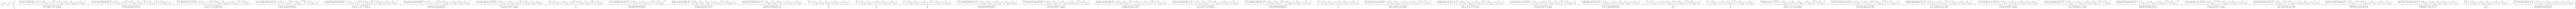

In [88]:
p=['d','u','u']
n=['d','d','u']
Kp=['sb','u']
K0=['sb','d']
Kb0=['db','s']
Km=['ub','s']
eta=[['ub','u'],['db','d'],['sb','s']]
Lambda0=['s','d','u']
Xi0=['s','s','u']
Xim=['s','s','d']
pip=['db','u']
pi0=[['ub','u'],['db','d']]
pim=['ub','d']
Sigmap=['s','u','u']
Sigma0=['s','d','u']
Sigmam=['s','d','d']


#position=['y\'','y\'','y\'','y','y','x','x','x\'','x\'','x\'']
position=['y','y','y','y','y','x','x','x','x','x']
#spin=['1','2','1','\\alpha','\\beta','\\sigma','\\rho','1','2','1']
spin=['1','2','1','\\alpha','\\alpha','\\sigma','\\sigma','1','2','1']
#spin=['1','2','1','\\alpha','\\beta','\\beta','\\alpha','1','2','1']
#spin=['1','2','1','1','1','1','1','1','2','1']
color=['c','b','a','i','j','j\'','i\'','a\'','b\'','c\'']
diquark=[[1,2],[7,8]]

#color1=['a','b','c']
#color2=['a\'','b\'','c\'']
color1=['0','1','2']
color2=['0','1','2']


def depth(L): return isinstance(L, list) and max(map(depth, L))+1


def add(baryon,meson):
    if depth(meson) != 1:
        output=[]
        for m in meson:
            output.append(add(baryon,m))
        return output
    else:
        return baryon+meson

#epsilon_tensor=symbols('\epsilon_{abc}\epsilon_{a\'b\'c\'}')*symbols('\gamma_5^{\\alpha\\beta}')*symbols('\gamma_5^{\\sigma\\rho}')
epsilon_tensor=symbols('\gamma_5^{\\alpha\\alpha}')*symbols('\gamma_5^{\\sigma\\sigma}')
#OVERALL_one=[-1/2/np.sqrt(2)/np.sqrt(3), -1/2/np.sqrt(2), -1/2/np.sqrt(2), 1/2/np.sqrt(2), 1/2/np.sqrt(2), 1/2*np.sqrt(3/2)/np.sqrt(3), 1/2*np.sqrt(3/2)/np.sqrt(3)/np.sqrt(2), 1/2*np.sqrt(3/2)/np.sqrt(3)]
OVERALL_one=[-1/2/np.sqrt(2)/np.sqrt(3), -1/2/np.sqrt(2),           1/2/np.sqrt(2),           1/2/np.sqrt(2),           -1/2/np.sqrt(2),            1/2*np.sqrt(3/2)/np.sqrt(3), -1/2*np.sqrt(3/2)/np.sqrt(3)/np.sqrt(3), 1/2*np.sqrt(3/2)/np.sqrt(3)]
OVERALL_eight=[-1/2/np.sqrt(2)/np.sqrt(3), -1/2/np.sqrt(2),           1/2/np.sqrt(2),           1/2/np.sqrt(2),           -1/2/np.sqrt(2),            1/2*np.sqrt(3/2)/np.sqrt(3), -1/2*np.sqrt(3/2)/np.sqrt(3)/np.sqrt(3), 1/2*np.sqrt(3/2)/np.sqrt(3)]
#OVERALL=[symbols('-1/2/\sqrt(2)'), symbols('-1/2/\sqrt(2)'), symbols('-1/2/\sqrt(2)'), symbols('1/2/\sqrt(2)'), symbols('1/2/\sqrt(2)'), symbols('1/2\sqrt(3/2)/\sqrt(3)'), symbols('1/2*np.sqrt(3/2)/\sqrt(3)'), symbols('1/2*np.sqrt(3/2)/\sqrt(3)')]
Q=[add(Lambda0,eta),add(p,Km),add(n,Kb0),add(Xi0,K0),add(Xim,Kp),add(Sigmam,pip),add(Sigma0,pi0),add(Sigmap,pim)]
#OVERALL_eight_reverse=deepcopy(OVERALL_eight)
#OVERALL_eight=deepcopy(OVERALL_one)
OVERALL_eight.reverse()

QUARK=[]
for q in Q:
    if depth(q) != 1:
        for qq in q:
            QUARK.append(qq)
    else:
        QUARK.append(q)

#display(QUARK)    
ANTIQUARK=[]
for quark in QUARK:
    quark_reverse=deepcopy(quark)
    quark_reverse.reverse()
    antiquark=[]
    for q in quark_reverse:
        antiquark.append(anti[q])
        
    ANTIQUARK.append(antiquark)

#display(ANTIQUARK)    

PRINT=0
for quark, coeff in zip(QUARK, OVERALL_one):
    for antiquark, coeff_reverse in zip(ANTIQUARK, OVERALL_eight):
        Overall=coeff*coeff_reverse*epsilon_tensor
        #print(quark+antiquark)
        output=[]
        OUTPUT=[]
        contraction(quark+antiquark,0,output,OUTPUT)
        PRINT+=print_Trace_color(OUTPUT,quark+antiquark,spin,color,position,Overall,diquark,spin_pair,color1,color2)
        
#display(simplify(PRINT))
display(nsimplify(simplify(PRINT),tolerance=1e-10))
#print(len(nsimplify(simplify(PRINT),tolerance=1e-10).args))
#print((PRINT).args)
#for term in nsimplify(simplify(PRINT),tolerance=1e-10).args:
#    print(term)

In [ ]:
p=['d','u','u']
n=['d','d','u']
Kp=['sb','u']
K0=['sb','d']
Kb0=['db','s']
Km=['ub','s']
eta=[['ub','u'],['db','d'],['sb','s']]
Lambda0=['s','d','u']
Xi0=['s','s','u']
Xim=['s','s','d']
pip=['db','u']
pi0=[['ub','u'],['db','d']]
pim=['ub','d']
Sigmap=['s','u','u']
Sigma0=['s','d','u']
Sigmam=['s','d','d']


#position=['y\'','y\'','y\'','y','y','x','x','x\'','x\'','x\'']
position=['y','y','y','y','y','x','x','x','x','x']
#spin=['1','2','1','\\alpha','\\beta','\\sigma','\\rho','1','2','1']
spin=['1','2','1','\\alpha','\\alpha','\\sigma','\\sigma','1','2','1']
#spin=['1','2','1','\\alpha','\\beta','\\beta','\\alpha','1','2','1']
#spin=['1','2','1','1','1','1','1','1','2','1']
color=['c','b','a','i','j','j\'','i\'','a\'','b\'','c\'']
diquark=[[1,2],[7,8]]

#color1=['a','b','c']
#color2=['a\'','b\'','c\'']
color1=['0','1','2']
color2=['0','1','2']


def depth(L): return isinstance(L, list) and max(map(depth, L))+1


def add(baryon,meson):
    if depth(meson) != 1:
        output=[]
        for m in meson:
            output.append(add(baryon,m))
        return output
    else:
        return baryon+meson

#epsilon_tensor=symbols('\epsilon_{abc}\epsilon_{a\'b\'c\'}')*symbols('\gamma_5^{\\alpha\\beta}')*symbols('\gamma_5^{\\sigma\\rho}')
epsilon_tensor=symbols('\gamma_5^{\\alpha\\alpha}')*symbols('\gamma_5^{\\sigma\\sigma}')
#OVERALL_one=[-1/2/np.sqrt(2)/np.sqrt(3), -1/2/np.sqrt(2), -1/2/np.sqrt(2), 1/2/np.sqrt(2), 1/2/np.sqrt(2), 1/2*np.sqrt(3/2)/np.sqrt(3), 1/2*np.sqrt(3/2)/np.sqrt(3)/np.sqrt(2), 1/2*np.sqrt(3/2)/np.sqrt(3)]
OVERALL_one=[-1/2/np.sqrt(2)/np.sqrt(3), -1/2/np.sqrt(2),           1/2/np.sqrt(2),           1/2/np.sqrt(2),           -1/2/np.sqrt(2),            1/2*np.sqrt(3/2)/np.sqrt(3), -1/2*np.sqrt(3/2)/np.sqrt(3)/np.sqrt(3), 1/2*np.sqrt(3/2)/np.sqrt(3)]
OVERALL_eight=[-1/np.sqrt(5)/np.sqrt(3), -1/np.sqrt(10)/np.sqrt(2), 1/np.sqrt(10)/np.sqrt(2), 1/np.sqrt(10)/np.sqrt(2), -1/np.sqrt(10)/np.sqrt(2), -1/np.sqrt(3/5)/np.sqrt(3),    1/np.sqrt(3/5)/np.sqrt(3)/np.sqrt(3),  -1/np.sqrt(3/5)/np.sqrt(3)]
#OVERALL=[symbols('-1/2/\sqrt(2)'), symbols('-1/2/\sqrt(2)'), symbols('-1/2/\sqrt(2)'), symbols('1/2/\sqrt(2)'), symbols('1/2/\sqrt(2)'), symbols('1/2\sqrt(3/2)/\sqrt(3)'), symbols('1/2*np.sqrt(3/2)/\sqrt(3)'), symbols('1/2*np.sqrt(3/2)/\sqrt(3)')]
Q=[add(Lambda0,eta),add(p,Km),add(n,Kb0),add(Xi0,K0),add(Xim,Kp),add(Sigmam,pip),add(Sigma0,pi0),add(Sigmap,pim)]
#OVERALL_eight_reverse=deepcopy(OVERALL_eight)
OVERALL_one=deepcopy(OVERALL_eight)
OVERALL_eight.reverse()

QUARK=[]
for q in Q:
    if depth(q) != 1:
        for qq in q:
            QUARK.append(qq)
    else:
        QUARK.append(q)

#display(QUARK)    
ANTIQUARK=[]
for quark in QUARK:
    quark_reverse=deepcopy(quark)
    quark_reverse.reverse()
    antiquark=[]
    for q in quark_reverse:
        antiquark.append(anti[q])
        
    ANTIQUARK.append(antiquark)

#display(ANTIQUARK)    

PRINT=0
for quark, coeff in zip(QUARK, OVERALL_one):
    for antiquark, coeff_reverse in zip(ANTIQUARK, OVERALL_eight):
        Overall=coeff*coeff_reverse*epsilon_tensor
        #print(quark+antiquark)
        output=[]
        OUTPUT=[]
        contraction(quark+antiquark,0,output,OUTPUT)
        #PRINT+=print_Trace_color(OUTPUT,quark+antiquark,spin,color,position,Overall,diquark,spin_pair,color1,color2)
        
        for a in ['0','1','2']:
            color[2]=a
            for b in ['0','1','2']:
                if a==b: continue
                color[1]=b
                for c in ['0','1','2']:
                    if c==a or c==b: continue
                    color[0]=c
                    for aa in ['0','1','2']:
                        color[7]=aa
                        for bb in ['0','1','2']:
                            if aa==bb: continue
                            color[8]=bb
                            for cc in ['0','1','2']:
                                if cc==aa or cc==bb: continue
                                color[9]=cc
                                #print(color)
                                perm1=Permutation(color[:3])
                                perm2=Permutation(color[7:])

                                sign1=perm1.signature()
                                sign2=perm2.signature()
                                for i in ['0','1','2']:
                                    color[3]=i
                                    for j in ['0','1','2']:
                                        color[4]=j
                                        for jj in ['0','1','2']:
                                            color[5]=jj
                                            for ii in ['0','1','2']:
                                                color[6]=ii

                                                PRINT+=print_propagator_with_diquark_color(OUTPUT,quark+antiquark,spin,color,position,Overall,diquark, color1, color2)

#display(simplify(PRINT))
display(nsimplify(simplify(PRINT),tolerance=1e-10))
#print(len(nsimplify(simplify(PRINT),tolerance=1e-10).args))
#print((PRINT).args)
#for term in nsimplify(simplify(PRINT),tolerance=1e-10).args:
#    print(term)